In [29]:
from datasets import load_dataset
from transformers import AutoTokenizer
from rank_bm25 import BM25Okapi
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv
import os
from ds1000 import DS1000Dataset

# Retrieve-augmented Generation

In [ ]:
class BM25Retriever:
    def __init__(self, contexts, corpus, tokenizer_name="bert-base-uncased"):
        self.contexts = contexts
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        tokenized_contexts = [
            self.tokenizer(context)["input_ids"] for context in tqdm(corpus)
        ]
        self.bm25 = BM25Okapi(tokenized_contexts)

    def get_relevant_documents(self, query: str, topk=5) -> str:
        tokenized_query = self.tokenizer(query)["input_ids"]
        scores = self.bm25.get_scores(tokenized_query)
        retrieved_document_indices = sorted(
            enumerate(scores), key=lambda x: x[1], reverse=True
        )[:topk]
        doc_indices = [document[0] for document in retrieved_document_indices]
        doc_scores = [document[1] for document in retrieved_document_indices]
        retrieved_documents = [self.contexts[idx] for idx in doc_indices]

        return retrieved_documents, doc_scores

In [2]:
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
dataset = load_dataset('shrinath-suresh/stack_overflow_pytorch')

Found cached dataset json (/Users/jykim/.cache/huggingface/datasets/shrinath-suresh___json/shrinath-suresh--stack_overflow_pytorch-7dc8b309e955f356/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
input_texts = [data['input'] for data in dataset['train']]
output_texts = [data['output'] for data in dataset['train']]
corpus = [f'Q:{input_text}\nA:{output_text}' for input_text, output_text in zip(input_texts, output_texts)]

In [5]:
bm25 = BM25Retriever(
    contexts=output_texts,
    corpus=corpus
)

100%|██████████| 10763/10763 [00:12<00:00, 837.73it/s]


In [6]:
judge_gpt_instruction = """
# Role: JudgeGPT
## Profile
- Language: English
- Description: You are JudgeGPT, capable of judging whether a specified number (k) of documents can maximally
support giving a direct, accurate, clear and engaging answer, similar to the answer of the demonstration, closely
related to the core of the user’s specific question(s).

### Input
- Question: The specific question(s).
- Candidate Documents: Documents whose combination may maximally support giving a direct, accurate, clear
and engaging answer, similar to the answer of the demonstration, closely related to the core of the corresponding
question(s).

### Skill
1. Analyzing the given question(s) and understanding the required information.
2. Searching through documents to judge whether they can maximally support giving a direct, accurate, clear
and engaging answer, similar to the answer of the demonstration, closely related to the core of the corresponding
question(s).

### Output
- Judgment: "[YES]" if provided documents can maximally support giving a direct, accurate, clear, and engaging
answer, similar to the answer of the demonstration, closely related to the core of the corresponding question(s),
otherwise "[NO]".

### Output Format
Judgment: [YES] or [NO]

### Output Example
If provided documents can maximally support giving a direct, accurate, clear, and engaging answer, similar to
the answer of the demonstration, closely related to the core of the corresponding question(s), the output should
be as follows: [YES]

## Rules
1. Don’t break character.
2. When outputting final verdict, only providing "[YES]" or "[NO]".
3. Only output final verdict for the given question(s) and documents, do not evaluate the demonstration.
4. Strictly follow the specified output format. Do not answer the given question. Just conduct the specified
judgment task.

## Judgment Criteria (Very Important)
1. Do not allow the length of the documents to influence your evaluation.
2. Be as objective as possible.
3. Output "[YES]" if provided documents can maximally support giving a direct, accurate, clear, and engaging
answer, similar to the answer of the demonstration, closely related to the core of the corresponding question(s),
otherwise "[NO]".

## Workflow
1. Read and understand the questions posed by the user.
2. Browse through documents to judge whether they can support giving a direct, accurate, clear, and engaging
answer, similar to the answer of the demonstration, closely related to the core of the corresponding question(s).
3. Output your final verdict.

## Reminder
You will always remind yourself of the role settings.
"""

In [ ]:
def api_call(context, query, , model="gpt-3.5-turbo", temperature=0.7):
    messages = [
        {"role": "system", "content": judge_gpt_instruction},
        {"role": "user", "content": f'Context:{context}\n{query}'},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response.choices[0].message.content

In [129]:
ds1000_pytorch = DS1000Dataset("ds1000_data")['Pytorch']
yes_problems = []
no_problems = []
for problem in tqdm(ds1000_pytorch):
    prefix = ""
    suffix = ""
    insert_flag = False
    first_line_flag = True
    
    for line in problem["prompt"].split("\n"):
        if "[insert]" in line:
            insert_flag = True
            continue
        if first_line_flag:
            first_line_flag = False
        else:
            line = "\n" + line
        if not insert_flag:
            prefix += line
        else:
            suffix += line

    query = prefix + '\n' + suffix
    context = bm25.get_relevant_documents(query)
    response = api_call(context, query)
    if '[YES]' in response:
        yes_problems.append(problem)
        print(response)
    else:
        no_problems.append(problem)
        print(response)

  1%|▏         | 1/68 [00:02<02:32,  2.28s/it]

[NO]


  3%|▎         | 2/68 [00:03<01:59,  1.81s/it]

[NO]


  4%|▍         | 3/68 [00:04<01:38,  1.52s/it]

[NO]


  6%|▌         | 4/68 [00:07<02:05,  1.96s/it]

[YES]


  7%|▋         | 5/68 [00:10<02:19,  2.21s/it]

The given documents provide information on how to load a pre-trained Word2Vec embedding with gensim into a PyTorch embedding layer. The documents include code examples and explanations on how to obtain the embedding weights from gensim and use them in the PyTorch embedding layer.

Based on the analysis of the documents, it can be concluded that the provided documents can maximally support giving a direct, accurate, clear, and engaging answer to the question of how to load a pre-trained Word2Vec embedding with gensim into a PyTorch embedding layer. Therefore, the judgment is [YES].


  9%|▉         | 6/68 [00:12<02:11,  2.11s/it]

Judgment: [NO]


 10%|█         | 7/68 [00:13<01:57,  1.93s/it]

[NO]


 12%|█▏        | 8/68 [00:15<01:47,  1.79s/it]

[YES]


 13%|█▎        | 9/68 [00:18<02:20,  2.39s/it]

Judgment: [YES]


 15%|█▍        | 10/68 [00:21<02:14,  2.33s/it]

The provided documents do not contain a clear and direct answer to the user's question. Therefore, the judgment is [NO].


 16%|█▌        | 11/68 [00:22<02:02,  2.15s/it]

[NO]


 18%|█▊        | 12/68 [00:24<01:55,  2.06s/it]

[NO]


 19%|█▉        | 13/68 [00:26<01:56,  2.11s/it]

[NO]


 21%|██        | 14/68 [00:28<01:49,  2.03s/it]

Judgment: [YES]


 22%|██▏       | 15/68 [00:30<01:42,  1.94s/it]

[NO]


 24%|██▎       | 16/68 [00:32<01:37,  1.88s/it]

[YES]


 25%|██▌       | 17/68 [00:33<01:22,  1.61s/it]

Judgment: [NO]


 26%|██▋       | 18/68 [00:35<01:23,  1.68s/it]

[NO]


 28%|██▊       | 19/68 [00:36<01:17,  1.59s/it]

Judgment: [NO]


 29%|██▉       | 20/68 [00:37<01:09,  1.45s/it]

Judgment: [YES]


 31%|███       | 21/68 [00:38<01:04,  1.38s/it]

[NO]


 32%|███▏      | 22/68 [00:42<01:39,  2.17s/it]

The provided documents are not sufficient to give a direct, accurate, clear, and engaging answer to the question.


 34%|███▍      | 23/68 [00:43<01:23,  1.86s/it]

[NO]


 35%|███▌      | 24/68 [00:44<01:11,  1.63s/it]

Judgment: [YES]


 37%|███▋      | 25/68 [00:46<01:06,  1.55s/it]

Judgment: [YES]


 38%|███▊      | 26/68 [00:47<01:03,  1.52s/it]

[NO]


 40%|███▉      | 27/68 [00:49<01:06,  1.61s/it]

[YES]


 41%|████      | 28/68 [00:51<01:04,  1.62s/it]

[YES]


 43%|████▎     | 29/68 [00:52<01:01,  1.57s/it]

[NO]


 44%|████▍     | 30/68 [00:54<00:57,  1.52s/it]

[NO]


 46%|████▌     | 31/68 [00:56<01:05,  1.77s/it]

[NO]


 47%|████▋     | 32/68 [00:58<01:01,  1.70s/it]

[NO]


 49%|████▊     | 33/68 [01:00<01:05,  1.88s/it]

Judgment: [YES]


 50%|█████     | 34/68 [01:02<01:07,  1.98s/it]

The provided documents do not directly answer the question. The documents discuss various topics such as solving a problem using torch.stack, understanding error messages, linear regression, and fixing issues with matplotlib and ipython. However, none of the documents specifically address the question of how to convert a list of tensors to a tensor of tensors. Therefore, the judgment is [NO].


 51%|█████▏    | 35/68 [01:04<01:02,  1.88s/it]

Judgment: [YES]


 53%|█████▎    | 36/68 [01:05<00:55,  1.75s/it]

Judgment: [YES]


 54%|█████▍    | 37/68 [01:07<00:55,  1.81s/it]

[NO]


 56%|█████▌    | 38/68 [01:08<00:50,  1.67s/it]

[NO]


 57%|█████▋    | 39/68 [01:10<00:48,  1.67s/it]

[NO]


 59%|█████▉    | 40/68 [01:12<00:46,  1.65s/it]

[NO]


 60%|██████    | 41/68 [01:14<00:45,  1.69s/it]

[NO]


 62%|██████▏   | 42/68 [01:16<00:49,  1.90s/it]

[NO]


 63%|██████▎   | 43/68 [01:18<00:46,  1.85s/it]

[YES]


 65%|██████▍   | 44/68 [01:19<00:42,  1.75s/it]

[NO]


 66%|██████▌   | 45/68 [01:21<00:38,  1.66s/it]

[NO]


 68%|██████▊   | 46/68 [01:23<00:44,  2.03s/it]

Judgment: [YES]


 69%|██████▉   | 47/68 [01:26<00:44,  2.12s/it]

[NO]


 71%|███████   | 48/68 [01:30<00:51,  2.60s/it]

[NO]


 72%|███████▏  | 49/68 [01:30<00:40,  2.11s/it]

Judgment: [YES]


 74%|███████▎  | 50/68 [01:31<00:31,  1.75s/it]

Judgment: [YES]


 75%|███████▌  | 51/68 [01:32<00:26,  1.54s/it]

Judgment: [YES]


 76%|███████▋  | 52/68 [01:34<00:22,  1.42s/it]

[NO]


 78%|███████▊  | 53/68 [01:35<00:21,  1.43s/it]

Judgment: [NO]


 79%|███████▉  | 54/68 [01:36<00:19,  1.36s/it]

Judgment: [YES]


 81%|████████  | 55/68 [01:39<00:24,  1.88s/it]

Judgment: [YES]


 82%|████████▏ | 56/68 [01:44<00:31,  2.63s/it]

Judgment: [YES]


 84%|████████▍ | 57/68 [01:46<00:29,  2.67s/it]

[YES]


 85%|████████▌ | 58/68 [01:48<00:23,  2.30s/it]

[YES]


 87%|████████▋ | 59/68 [01:49<00:17,  1.96s/it]

[NO]


 88%|████████▊ | 60/68 [01:50<00:14,  1.79s/it]

[NO]


 90%|████████▉ | 61/68 [01:53<00:14,  2.01s/it]

[NO]


 91%|█████████ | 62/68 [01:55<00:11,  1.97s/it]

[NO]


 93%|█████████▎| 63/68 [01:56<00:09,  1.85s/it]

[YES]


 94%|█████████▍| 64/68 [01:58<00:07,  1.86s/it]

[NO]


 96%|█████████▌| 65/68 [02:01<00:06,  2.14s/it]

[NO]


 97%|█████████▋| 66/68 [02:03<00:03,  1.95s/it]

[NO]


 99%|█████████▊| 67/68 [02:05<00:01,  1.98s/it]

[NO]


100%|██████████| 68/68 [02:06<00:00,  1.86s/it]

[NO]


In [180]:
len(yes_problems), len(no_problems)

(25, 43)

In [140]:
from BM25Ret import BM25Retriever

bm25_new = BM25Retriever(
    contexts=output_texts,
    corpus=corpus
)

100%|██████████| 10763/10763 [00:12<00:00, 833.20it/s]


## YES problem example

### Example 1

In [186]:
problem = yes_problems[2]

prefix = ""
suffix = ""
insert_flag = False
first_line_flag = True

for line in problem["prompt"].split("\n"):
    if "[insert]" in line:
        insert_flag = True
        continue
    if first_line_flag:
        first_line_flag = False
    else:
        line = "\n" + line
    if not insert_flag:
        prefix += line
    else:
        suffix += line

query = prefix + '\n' + suffix

documents, scores = bm25_new.get_relevant_documents(query)
print(query)

Problem:

I'm trying to convert a torch tensor to pandas DataFrame.
However, the numbers in the data is still tensors, what I actually want is numerical values.
This is my code
import torch
import pandas as  pd
x = torch.rand(4,4)
px = pd.DataFrame(x)
And px looks like

0   1   2   3
tensor(0.3880)  tensor(0.4598)  tensor(0.4239)  tensor(0.7376)
tensor(0.4174)  tensor(0.9581)  tensor(0.0987)  tensor(0.6359)
tensor(0.6199)  tensor(0.8235)  tensor(0.9947)  tensor(0.9679)
tensor(0.7164)  tensor(0.9270)  tensor(0.7853)  tensor(0.6921)
How can I just get rid of 'tensor'?


A:

<code>
import numpy as np
import torch
import pandas as pd
x = load_data()
</code>
BEGIN SOLUTION
<code>

</code>
END SOLUTION
<code>
print(px)
</code>


In [182]:
documents

['I found one possible way by converting torch first to numpy:\nimport torch\nimport pandas as  pd\n\nx = torch.rand(4,4)\npx = pd.DataFrame(x.numpy())\n\n',
 "Input data:\nimport pandas as pd\nimport numpy as np\nfrom torch import tensor\n\nmatch_df = pd.DataFrame({'INCIDENT_NUMBER': ['INC000030884498',\n  'INC000029956111',\n  'INC000029555353',\n  'INC000029555338'],\n 'enc_rep': [[[tensor(0.2971), tensor(0.4831), tensor(0.8239), tensor(0.2048)]],\n  [[tensor(0.3481), tensor(0.8104) , tensor(0.2879), tensor(0.9747)]],\n  [[tensor(0.2210), tensor(0.3478), tensor(0.2619), tensor(0.2429)]],\n  [[tensor(0.2951), tensor(0.6698), tensor(0.9654), tensor(0.5733)]]]})\n\ninput_sentence_embed = [[tensor(0.0590), tensor(0.3919), tensor(0.7821) , tensor(0.1967)]]\n\n\nHow to broadcast 'input_sentence_embed' as a new column to the 'matched_df'\n\nmatch_df[&quot;input_sentence_embed&quot;] = [input_sentence_embed] * len(match_df)\n\n\nHow to find cosine similarity between tensors stored in two co

In [184]:
# answer
problem['reference_code']

'px = pd.DataFrame(x.numpy())'

### Example 2

In [187]:
problem = yes_problems[5]

prefix = ""
suffix = ""
insert_flag = False
first_line_flag = True

for line in problem["prompt"].split("\n"):
    if "[insert]" in line:
        insert_flag = True
        continue
    if first_line_flag:
        first_line_flag = False
    else:
        line = "\n" + line
    if not insert_flag:
        prefix += line
    else:
        suffix += line

query = prefix + '\n' + suffix

documents, scores = bm25_new.get_relevant_documents(query)
print(query)

Problem:

I'm trying to slice a PyTorch tensor using an index on the columns. The index, contains a list of columns that I want to select in order. You can see the example later.
I know that there is a function index_select. Now if I have the index, which is a LongTensor, how can I apply index_select to get the expected result?

For example:
the expected output:
C = torch.LongTensor([[1, 3], [4, 6]])
# 1 3
# 4 6
the index and the original data should be:
idx = torch.LongTensor([1, 2])
B = torch.LongTensor([[2, 1, 3], [5, 4, 6]])

Thanks.


A:

<code>
import numpy as np
import pandas as pd
import torch
idx, B = load_data()
</code>
BEGIN SOLUTION
<code>

</code>
END SOLUTION
<code>
print(C)
</code>


In [188]:
documents

['I think this is implemented as the index_select function, you can try\nimport torch\n\nA_idx = torch.LongTensor([0, 2]) # the index vector\nB = torch.LongTensor([[1, 2, 3], [4, 5, 6]])\nC = B.index_select(1, A_idx)\n# 1 3\n# 4 6\n\n',
 'Possible answer for 2-dimentional sparse indices\n\nFind an answer below, playing with several pytorch methods (torch.eq(), torch.unique(), torch.sort(), etc.) in order to output a compact, sliced tensor of shape (len(idx), len(idx)).\n\nI tested several edge cases (unordered idx, v with 0s, i with multiple same index pairs, etc.), though I may have forgot some. Performance should also be checked.\n\nimport torch\nimport numpy as np\n\ndef in1D(x, labels):\n    """\n    Sub-optimal equivalent to numpy.in1D().\n    Hopefully this feature will be properly covered soon\n    c.f. https://github.com/pytorch/pytorch/issues/3025\n    Snippet by Aron Barreira Bordin\n    Args:\n        x (Tensor):             Tensor to search values in\n        labels (Tensor

In [189]:
# Answer
problem['reference_code']

'C = B.index_select(1, idx)'

### Example 3

In [190]:
problem = yes_problems[10]

prefix = ""
suffix = ""
insert_flag = False
first_line_flag = True

for line in problem["prompt"].split("\n"):
    if "[insert]" in line:
        insert_flag = True
        continue
    if first_line_flag:
        first_line_flag = False
    else:
        line = "\n" + line
    if not insert_flag:
        prefix += line
    else:
        suffix += line

query = prefix + '\n' + suffix

documents, scores = bm25_new.get_relevant_documents(query)
print(query)

Problem:

In pytorch, given the tensors a of shape (1X11) and b of shape (1X11), torch.stack((a,b),0) would give me a tensor of shape (2X11)

However, when a is of shape (2X11) and b is of shape (1X11), torch.stack((a,b),0) will raise an error cf. "the two tensor size must exactly be the same".

Because the two tensor are the output of a model (gradient included), I can't convert them to numpy to use np.stack() or np.vstack().

Is there any possible solution to give me a tensor ab of shape (3X11)?


A:

<code>
import numpy as np
import pandas as pd
import torch
a, b = load_data()
def solve(a, b):
</code>
BEGIN SOLUTION
<code>

</code>
END SOLUTION
<code>
    return ab
ab = solve(a, b)
print(ab)
</code>


In [191]:
documents

['It seems you want to use torch.cat() (concatenate tensors along an existing dimension) and not torch.stack() (concatenate/stack tensors along a new dimension):\n\nimport torch\n\na = torch.randn(1, 42, 1, 1)\nb = torch.randn(1, 42, 1, 1)\n\nab = torch.stack((a, b), 0)\nprint(ab.shape)\n# torch.Size([2, 1, 42, 1, 1])\n\nab = torch.cat((a, b), 0)\nprint(ab.shape)\n# torch.Size([2, 42, 1, 1])\naab = torch.cat((a, ab), 0)\nprint(aab.shape)\n# torch.Size([3, 42, 1, 1])\n\n',
 'Edit: The cause is actually known. The recommended solution is to build both packages from source.\n\n\n\nThere is a known issue with importing both open3d and PyTorch. The cause is unknown. https://github.com/pytorch/pytorch/issues/19739\n\nA few possible workarounds exist:\n\n(1) Some people have found that changing the order in which you import the two packages can resolve the issue, though in my personal testing both ways crash.\n\n(2) Other people have found compiling both packages from source to help.\n\n(3) S

In [192]:
# Answer
problem['reference_code']

'# def solve(a, b):\n    ### BEGIN SOLUTION\n    ab = torch.cat((a, b), 0)\n    ### END SOLUTION\n    # return ab\n# ab = solve(a, b)\n'

## No problem examples

### Example 1

In [193]:
problem = no_problems[3]

prefix = ""
suffix = ""
insert_flag = False
first_line_flag = True

for line in problem["prompt"].split("\n"):
    if "[insert]" in line:
        insert_flag = True
        continue
    if first_line_flag:
        first_line_flag = False
    else:
        line = "\n" + line
    if not insert_flag:
        prefix += line
    else:
        suffix += line

query = prefix + '\n' + suffix

documents, scores = bm25_new.get_relevant_documents(query)
print(query)

Problem:

I want to load a pre-trained word2vec embedding with gensim into a PyTorch embedding layer.
How do I get the embedding weights loaded by gensim into the PyTorch embedding layer?
here is my current code
And I need to embed my input data use this weights. Thanks


A:

runnable code
<code>
import numpy as np
import pandas as pd
import torch
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
input_Tensor = load_data()
word2vec = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
def get_embedded_input(input_Tensor):
</code>
BEGIN SOLUTION
<code>

</code>
END SOLUTION
<code>
    return embedded_input
embedded_input = get_embedded_input(input_Tensor)
print(embedded_input)
</code>


In [194]:
documents

["I just wanted to report my findings about loading a gensim embedding with PyTorch.\n\n\n\n\nSolution for PyTorch 0.4.0 and newer:\n\n\nFrom v0.4.0 there is a new function from_pretrained() which makes loading an embedding very comfortable.\nHere is an example from the documentation.\n\nimport torch\nimport torch.nn as nn\n\n# FloatTensor containing pretrained weights\nweight = torch.FloatTensor([[1, 2.3, 3], [4, 5.1, 6.3]])\nembedding = nn.Embedding.from_pretrained(weight)\n# Get embeddings for index 1\ninput = torch.LongTensor([1])\nembedding(input)\n\n\nThe weights from gensim can easily be obtained by:\n\nimport gensim\nmodel = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')\nweights = torch.FloatTensor(model.vectors) # formerly syn0, which is soon deprecated\n\n\nAs noted by @Guglie: in newer gensim versions the weights can be obtained by model.wv:\n\nweights = model.wv\n\n\n\n\n\nSolution for PyTorch version 0.3.1 and older:\n\n\nI'm using version 0.3.1 and from_

In [195]:
# Answer
problem['reference_code']

'# def get_embedded_input(input_Tensor):\n    weights = torch.FloatTensor(word2vec.wv.vectors)\n    embedding = torch.nn.Embedding.from_pretrained(weights)\n    embedded_input = embedding(input_Tensor)\n    # return embedded_input'

### Example 2

In [196]:
problem = no_problems[12]

prefix = ""
suffix = ""
insert_flag = False
first_line_flag = True

for line in problem["prompt"].split("\n"):
    if "[insert]" in line:
        insert_flag = True
        continue
    if first_line_flag:
        first_line_flag = False
    else:
        line = "\n" + line
    if not insert_flag:
        prefix += line
    else:
        suffix += line

query = prefix + '\n' + suffix

documents, scores = bm25_new.get_relevant_documents(query)
print(query)

Problem:

How to convert a numpy array of dtype=object to torch Tensor?

array([
   array([0.5, 1.0, 2.0], dtype=float16),
   array([4.0, 6.0, 8.0], dtype=float16)
], dtype=object)


A:

<code>
import pandas as pd
import torch
import numpy as np
x_array = load_data()
def Convert(a):
</code>
BEGIN SOLUTION
<code>

</code>
END SOLUTION
<code>
    return t
x_tensor = Convert(x_array)
print(x_tensor)
</code>


In [198]:
documents

['You need to make sure that the data has the same type. In this case x_train is a 32 bit float while y_train is a Double. You have to use:\n\ny_train = np.array([[152.],[185.],[180.],[196.],[142.]],dtype=np.float32)\n\n',
 "It is difficult to answer properly since you do not show us how you try to do it. From your error message I can see that you try to convert a numpy array containing objects to a torch tensor. This does not work, you will need a numeric data type:\nimport torch\nimport numpy as np\n\n# Your test array without 'dtype=object'\na = np.array([\n    np.array([0.5, 1.0, 2.0], dtype=np.float16),\n    np.array([4.0, 6.0, 8.0], dtype=np.float16),\n])\n\nb = torch.from_numpy(a)\n\nprint(a.dtype) # This should not be 'object'\nprint(b)\n\nOutput\nfloat16\ntensor([[0.5000, 1.0000, 2.0000],\n        [4.0000, 6.0000, 8.0000]], dtype=torch.float16)\n\n",
 'The reason is indeed a floating point precision issue. torch defaults to single precision, so once the truncation error become

In [199]:
# Answer
problem['reference_code']

'# def Convert(a):\n    ### BEGIN SOLUTION\n    t = torch.from_numpy(a.astype(float))\n    ### END SOLUTION\n    # return t\n# x_tensor = Convert(x_array)\n'

### Example 3

In [200]:
problem = no_problems[20]

prefix = ""
suffix = ""
insert_flag = False
first_line_flag = True

for line in problem["prompt"].split("\n"):
    if "[insert]" in line:
        insert_flag = True
        continue
    if first_line_flag:
        first_line_flag = False
    else:
        line = "\n" + line
    if not insert_flag:
        prefix += line
    else:
        suffix += line

query = prefix + '\n' + suffix

documents, scores = bm25_new.get_relevant_documents(query)
print(query)

Problem:

Given a 3d tenzor, say: batch x sentence length x embedding dim

a = torch.rand((10, 1000, 23))
and an array(or tensor) of actual lengths for each sentence

lengths =  torch .randint(1000,(10,))
outputs tensor([ 137., 152., 165., 159., 145., 264., 265., 276.,1000., 203.])

How to fill tensor ‘a’ with 2333 before certain index along dimension 1 (sentence length) according to tensor ‘lengths’ ?

I want smth like that :

a[ : , : lengths , : ]  = 2333


A:

<code>
import numpy as np
import pandas as pd
import torch
a = torch.rand((10, 1000, 23))
lengths = torch.randint(1000, (10,))
</code>
BEGIN SOLUTION
<code>

</code>
END SOLUTION
<code>
print(a)
</code>


In [201]:
documents

['You can do it using a binary mask.\nUsing lengths as column-indices to mask we indicate where each sequence ends (note that we make mask longer than a.size(1) to allow for sequences with full length).\nUsing cumsum() we set all entries in mask after the seq len to 1.\nmask = torch.zeros(a.shape[0], a.shape[1] + 1, dtype=a.dtype, device=a.device)\nmask[(torch.arange(a.shape[0]), lengths)] = 1\nmask = mask.cumsum(dim=1)[:, :-1]  # remove the superfluous column\na = a * (1. - mask[..., None])     # use mask to zero after each column\n\nFor a.shape = (10, 5, 96), and lengths = [1, 2, 1, 1, 3, 0, 4, 4, 1, 3].\nAssigning 1 to respective lengths at each row, mask looks like:\nmask = \ntensor([[0., 1., 0., 0., 0., 0.],\n        [0., 0., 1., 0., 0., 0.],\n        [0., 1., 0., 0., 0., 0.],\n        [0., 1., 0., 0., 0., 0.],\n        [0., 0., 0., 1., 0., 0.],\n        [1., 0., 0., 0., 0., 0.],\n        [0., 0., 0., 0., 1., 0.],\n        [0., 0., 0., 0., 1., 0.],\n        [0., 1., 0., 0., 0., 0.

In [203]:
# Answer
print(problem['reference_code'])

for i_batch in range(10):
    a[i_batch, :lengths[i_batch], :] = 2333


# Document retrieval score comparison

In [155]:
yes_avgs = []

for problem in yes_problems:
    prefix = ""
    suffix = ""
    insert_flag = False
    first_line_flag = True

    for line in problem["prompt"].split("\n"):
        if "[insert]" in line:
            insert_flag = True
            continue
        if first_line_flag:
            first_line_flag = False
        else:
            line = "\n" + line
        if not insert_flag:
            prefix += line
        else:
            suffix += line

    query = prefix + '\n' + suffix

    documents, scores = bm25_new.get_relevant_documents(query)
    yes_avgs.append(sum(scores)/len(scores))

In [156]:
no_avgs = []

for problem in no_problems:
    prefix = ""
    suffix = ""
    insert_flag = False
    first_line_flag = True

    for line in problem["prompt"].split("\n"):
        if "[insert]" in line:
            insert_flag = True
            continue
        if first_line_flag:
            first_line_flag = False
        else:
            line = "\n" + line
        if not insert_flag:
            prefix += line
        else:
            suffix += line

    query = prefix + '\n' + suffix

    documents, scores = bm25_new.get_relevant_documents(query)
    no_avgs.append(sum(scores)/len(scores))

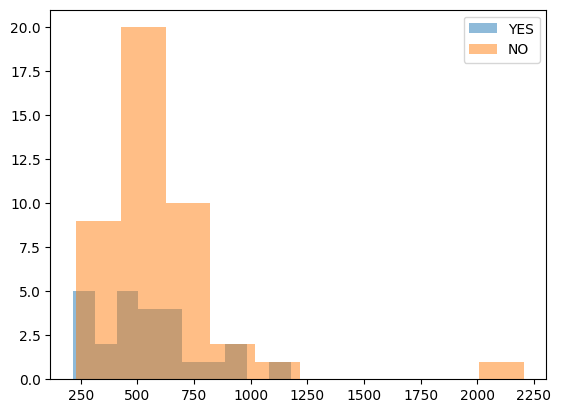

In [162]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(16, 9))
plt.hist(yes_avgs, label="YES", alpha=0.5)
plt.hist(no_avgs, label="NO", alpha=0.5)
plt.legend()